In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import json
import folium
import unidecode
import branca
import branca.colormap as cm
import matplotlib.pyplot as plt

%matplotlib inline

import findspark
findspark.init('../SPARK_HOME')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import lower, col

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Load Data

In [2]:
data = spark.read.option("delimiter", "\t").option("header", "true").csv("data/en.openfoodfacts.org.products.csv") 

### Clean Data

In [3]:
data.dtypes

[('code', 'string'),
 ('url', 'string'),
 ('creator', 'string'),
 ('created_t', 'string'),
 ('created_datetime', 'string'),
 ('last_modified_t', 'string'),
 ('last_modified_datetime', 'string'),
 ('product_name', 'string'),
 ('generic_name', 'string'),
 ('quantity', 'string'),
 ('packaging', 'string'),
 ('packaging_tags', 'string'),
 ('brands', 'string'),
 ('brands_tags', 'string'),
 ('categories', 'string'),
 ('categories_tags', 'string'),
 ('categories_en', 'string'),
 ('origins', 'string'),
 ('origins_tags', 'string'),
 ('manufacturing_places', 'string'),
 ('manufacturing_places_tags', 'string'),
 ('labels', 'string'),
 ('labels_tags', 'string'),
 ('labels_en', 'string'),
 ('emb_codes', 'string'),
 ('emb_codes_tags', 'string'),
 ('first_packaging_code_geo', 'string'),
 ('cities', 'string'),
 ('cities_tags', 'string'),
 ('purchase_places', 'string'),
 ('stores', 'string'),
 ('countries', 'string'),
 ('countries_tags', 'string'),
 ('countries_en', 'string'),
 ('ingredients_text', 'str

In [4]:
data.count()

692133

#### Origins

In [5]:
origins = data.groupBy("origins").count()
origins.count()

7477

This is 7462 dinstinct origin countries. This is inconvenient as we are interested in the independant states only
We therefore want to normalize this data. 

In [6]:
data.filter(data.origins_tags != "").groupBy("origins_tags").count().count()

6653

This category actually shows less 

In [7]:
def convert(unicodestring):
    return unidecode.unidecode(unicodestring)

udf_remove_accent = udf(convert)

origins_formated = data.filter(data.origins != "") \
                        .withColumn("origins", lower(col("origins"))) \
                        .withColumn("origins", udf_remove_accent(col("origins"))) \
                        .select("origins")

origins_grouped = origins_formated.groupBy("origins").count()
origins_grouped.sort(origins_grouped["count"].desc()).count()

6832

We might want to split data on strings, explode and then groupBy again 

In [9]:
countries_fr = spark.read.csv("data/countries_fr.csv").drop("_c0","_c2")
countries_fr = countries_fr.withColumnRenamed("_c1", "country-code") \
            .withColumnRenamed("_c3", "alpha-3") \
            .withColumnRenamed("_c4", "name_fr") \
            .withColumnRenamed("_c5", "name_en") 
countries_fr.show(5)
print(countries_fr.count())

+------------+-------+-----------------+--------------+
|country-code|alpha-3|          name_fr|       name_en|
+------------+-------+-----------------+--------------+
|           4|    AFG|      Afghanistan|   Afghanistan|
|           8|    ALB|          Albanie|       Albania|
|          10|    ATA|      Antarctique|    Antarctica|
|          12|    DZA|          Algérie|       Algeria|
|          16|    ASM|Samoa Américaines|American Samoa|
+------------+-------+-----------------+--------------+
only showing top 5 rows

241


In [11]:
countries_formatted = countries_fr.withColumn("name_fr", lower(col("name_fr")))\
                                .withColumn("name_fr", udf_remove_accent(col("name_fr")))\
                                .withColumn("name_en", lower(col("name_en")))\
                                .withColumn("name_en", udf_remove_accent(col("name_en")))
countries_formatted.show(5)

+------------+-------+-----------------+--------------+
|country-code|alpha-3|          name_fr|       name_en|
+------------+-------+-----------------+--------------+
|           4|    AFG|      afghanistan|   afghanistan|
|           8|    ALB|          albanie|       albania|
|          10|    ATA|      antarctique|    antarctica|
|          12|    DZA|          algerie|       algeria|
|          16|    ASM|samoa americaines|american samoa|
+------------+-------+-----------------+--------------+
only showing top 5 rows



Vous êtes libre de partager, distribuer ou utiliser cette base de données, pour des utilisations commerciales ou non, à condition de conserver cette licence et d’attribuer un lien vers le site sql.sh.

Join with origin dataframe

In [12]:
origins_joined_en = origins_grouped.join(countries_formatted, countries_formatted.name_en == origins_grouped.origins, "inner") \
                                .select("origins", "count", "country-code","alpha-3") \
                                .withColumnRenamed("origins", "origins_en") \
                                .withColumnRenamed("count", "count_en") \
                                .withColumnRenamed("alpha-3", "alpha-3a")
origins_joined_en.count()

115

In [13]:
origins_joined_fr = origins_grouped.join(countries_formatted, countries_formatted.name_fr == origins_grouped.origins, "inner") \
                                .select("origins", "count", "country-code","alpha-3") \
                                .withColumnRenamed("origins", "origins_fr") \
                                .withColumnRenamed("count", "count_fr")
origins_joined_fr.count()

124

In [14]:
origins_joined = origins_joined_en.join(origins_joined_fr, ["country-code"], "outer")
origins_joined.count()

129

In [15]:
origins_joined.orderBy("country-code").drop("alpha-3a").show(5)

+------------+----------+--------+----------+--------+-------+
|country-code|origins_en|count_en|origins_fr|count_fr|alpha-3|
+------------+----------+--------+----------+--------+-------+
|         100|  bulgaria|       9|  bulgarie|      18|    BGR|
|         108|   burundi|       3|   burundi|       3|    BDI|
|         116|  cambodia|       4|  cambodge|      13|    KHM|
|          12|   algeria|       1|   algerie|      36|    DZA|
|         120|  cameroon|       8|  cameroun|       6|    CMR|
+------------+----------+--------+----------+--------+-------+
only showing top 5 rows



In [17]:
origins_total_1 = origins_joined.filter(origins_joined.origins_fr.isin(origins_joined.origins_en) == False)\
                .withColumn("total_count", col("count_en")+col("count_fr")) \
                .select("country-code", "origins_en", "total_count","alpha-3") \
                .orderBy("country-code")
origins_total_1.show(5)          

+------------+----------+-----------+-------+
|country-code|origins_en|total_count|alpha-3|
+------------+----------+-----------+-------+
|         100|  bulgaria|         27|    BGR|
|         116|  cambodia|         17|    KHM|
|          12|   algeria|         37|    DZA|
|         120|  cameroon|         14|    CMR|
|         152|     chile|         71|    CHL|
+------------+----------+-----------+-------+
only showing top 5 rows



In [18]:
origins_total_2 = origins_joined.filter(origins_joined.origins_fr.isin(origins_joined.origins_en) == True)\
                .withColumn("total_count", col("count_en")) \
                .select("country-code", "origins_en", "total_count","alpha-3") \
                .orderBy("country-code")
origins_total_2.show(5)

+------------+----------+-----------+-------+
|country-code|origins_en|total_count|alpha-3|
+------------+----------+-----------+-------+
|         108|   burundi|          3|    BDI|
|         124|    canada|        235|    CAN|
|         144| sri lanka|        102|    LKA|
|         158|    taiwan|         45|    TWN|
|         188|costa rica|         53|    CRI|
+------------+----------+-----------+-------+
only showing top 5 rows



In [19]:
origins_total = origins_total_1.union(origins_total_2)
origins_total.show(10)

+------------+--------------+-----------+-------+
|country-code|    origins_en|total_count|alpha-3|
+------------+--------------+-----------+-------+
|         100|      bulgaria|         27|    BGR|
|         116|      cambodia|         17|    KHM|
|          12|       algeria|         37|    DZA|
|         120|      cameroon|         14|    CMR|
|         152|         chile|         71|    CHL|
|         156|         china|        432|    CHN|
|         170|      colombia|         47|    COL|
|         191|       croatia|          7|    HRV|
|         196|        cyprus|          4|    CYP|
|         203|czech republic|         13|    CZE|
+------------+--------------+-----------+-------+
only showing top 10 rows



#### Packaging

In [505]:
data.filter(data.packaging != "").groupBy("packaging").count().count()

24968

In [506]:
data.filter(data.packaging_tags != "").groupBy("packaging_tags").count().count()

20115

#### Categories

In [ ]:
data.filter(data.categories != "").groupBy("categories").count().count()

In [ ]:
data.filter(data.categories_tags != "").groupBy("categories_tags").count().count()

## Analysis of Data

**Origins**

Text(0, 0.5, 'Number of countries')

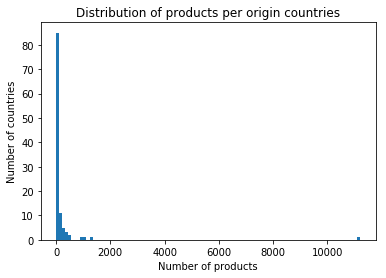

In [20]:
#Converting to Pandas
origins_total_pd = origins_total.toPandas()
countries_formatted_pd = countries_formatted.toPandas()

# Plot of the histogram
plt.hist(origins_total_pd['total_count'], bins = 100)
plt.title('Distribution of products per origin countries')
plt.xlabel('Number of products')
plt.ylabel('Number of countries')


Text(0, 0.5, 'Number of countries')

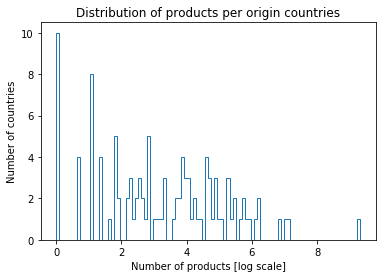

In [21]:
# Plot of the histogram in log scale
plt.hist(np.log(origins_total_pd['total_count']), histtype=u'step', bins = 100)
plt.title('Distribution of products per origin countries')
plt.xlabel('Number of products [log scale]')
plt.ylabel('Number of countries')
# J'arrive pas à tracer les max de ça, mais e pense que c'est linéaire! 

Text(0, 0.5, 'Number of countries')

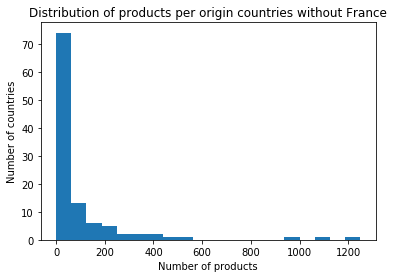

In [22]:
# There's an outlier at more than 10000 products:
# --> France is over-represented in the dataframe
plt.hist(origins_total_pd['total_count'], bins = 20, range=(0,1250))
plt.title('Distribution of products per origin countries without France')
plt.xlabel('Number of products')
plt.ylabel('Number of countries')

In [23]:
# Creating dataframes with only the interesting columns, adding counts of 0 for the countries where there's no products
origins_to_map = pd.DataFrame({'counts': origins_total_pd['total_count'].values, 'alpha-3':origins_total_pd['alpha-3'].values})
countries_formatted_pd = pd.DataFrame({'counts': np.zeros(len(countries_formatted_pd)), 'alpha-3':countries_formatted_pd['alpha-3'].values}) #,\
                            
# Merging the two dataframe, order by counts, then drop the first duplicate 
# By merging the dataframes, some countries are duplicates, so by doing this, 
# You make sure that it's the one with count 0 that is dropped. 
origins_to_map = origins_to_map.append(countries_formatted_pd, ignore_index=True)
origins_to_map = origins_to_map.sort_values('counts').drop_duplicates('alpha-3', keep = "last")

# creating a Serie that can be used in the colormap
S_origins_to_map =pd.Series(origins_to_map['counts'].values, index=origins_to_map['alpha-3'].values).astype(int)

# Some countries are missing from the csv file --> We have to manually add them. 
# Changes in JSON: for northern cyprus: '-99' --> NCYP, somalilia(?) '-99'--> SOMA
Missing_index = ['SSD','MNE','SRB','NCYP','SOMA','CS-KM']
Missing = pd.Series(np.zeros(6), index = Missing_index)
S_origins_to_map= S_origins_to_map.append(Missing)

Text(0.5, 1.0, 'Counts of 10 most popular origins')

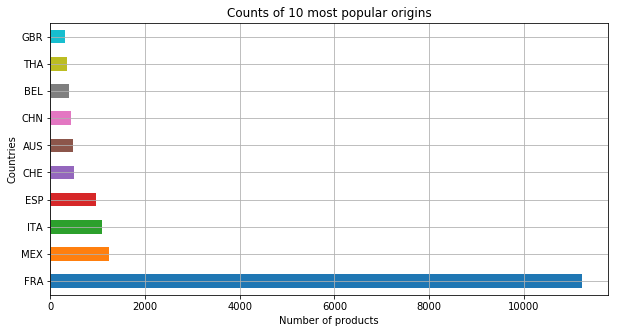

In [24]:
#Plot the counts of the 10 most popular tags
S_origins_to_map= S_origins_to_map.sort_values()
S_origins_to_map.tail(10).iloc[::-1].plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of products")
plt.ylabel("Countries")
plt.title("Counts of 10 most popular origins")

In [25]:
# loading a blank map 
Origins_map = folium.Map([0,0], tiles = 'cartodbpositron', zoom_start = 1.5)

# overlaying national borders
geo_json_data = json.load(open("data/countries.json"))

# defining the color scale
color_scale = branca.colormap.linear.Spectral_11.scale(0, 1500)
#color_scale = branca.colormap.linear.YlGnBu_09.scale(0, 1500)
#color_scale = branca.colormap.linear.YlOrRd_05.scale(0, 1500)
color_scale.caption = 'Number of products coming from the country'
Origins_map.add_child(color_scale)

# style function based on the color scale
def style_function(feature):
    value = S_origins_to_map.get(feature['id'])
    return {  
        'fillOpacity': 0.7,
        'weight': 0.7,
        'color': '#000000',
        'fillColor': '#708090' if (value==0) else color_scale(value)
    }

# adding the style function to the map
folium.TopoJson(
        geo_json_data,
        'objects.countries1',
        style_function = style_function,
        tooltip = folium.GeoJsonTooltip(['name'], labels = False, style = 'font-size:10px')
    ).add_to(Origins_map)

Origins_map